<a href="https://colab.research.google.com/github/seoyun2/exploration/blob/main/Exploration5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploration5 : 나랑 닮은 연예인은 누구?
학습목표

1. 임베딩에 대해 이해하고 얼굴의 임베딩 벡터를 추출합니다.
2. 얼굴의 임베딩 벡터로 닮은 꼴인 얼굴을 찾습니다.
3. 나와 가까운 연예인을 찾아냅니다.

## 임베딩은 무엇일까?
컴퓨터에게 우리가 다양한 형태의 정보를 표현하는 방법은, __어떤 벡터 공간(Vector Space)__에 우리가 표현하고자 하는 정보를 사상(maping)하는 방법밖에 없음.

우리가 단어이든, 이미지 오브젝트이든 무언가를 벡터로 표현한다면, 그것은 원점에서 출발한 벡터 공간상의 한 점이 될 것

그러므로, 우리가 하고 싶은 것들은 모두 두 점 사이의 관계를 따져보고 싶은 것으로 귀결됨

오늘 다루어 보고자 하는 __두 얼굴이 얼마나 닮았나__ 하는 문제도 컴퓨터한테는 __두 얼굴 벡터 사이의 거리가 얼마나 되나__ 하는 문제로 치환됨

중요한 것은 두 점 사이의 거리가 실제로 두 오브젝트 사이의 유사도를 정확하게 반영해야 한다는 점

먼저 얼굴이 있는 가로, 세로가 100 pixel인 두 이미지가 있다고 생각해보면 이미지가 동일하다면 이미지의 픽셀 수준에서 두 이미지 사이의 거리는 0이라고 볼 수 있음

하지만 픽셀 단위로 비교하는 방식으로는 두 사진 속의 얼굴이 동일한지 판단하기 어려움. 사진이 가로x세로 100x100 pixel의 컬러 사진이라면 RGB 3개의 채널이 존재하므로 100x100x3 = 30000 차원의 벡터를 얼굴 개수만큼 비교해야 하는 일이 생김.

너무 차원수가 높은 픽셀 공간에서의 비교는 사실상 무의미해짐. 완전 동일한 두 이미지 중 하나를 한 픽셀만 오른쪽으로 shift한 후 비교한다고 생각해 보자. 육안으로는 두 사진의 차이를 구분조차 할 수 없겠지만 픽셀 공간에서 비교하면 갑자기 큰 차이가 생김. 고차원의 공간은 우리가 인지조차 못할만큼의 너무 미세한 정보를 담고 있기 때문에 여기서 측정한 상대적 거리가 유의미한 유사성이나 차이를 보이는지 확인하기가 어려움.

이 문제를 해결하기 위해서 얼굴을 표현하는 이미지 벡터를 더 작은 차원으로 줄일 수 있지 않을까? 이렇게 고차원 정보를 저차원으로 변환하면서 필요한 정보를 보존하는 것이 임베딩. 얼굴 이미지가 저차원으로 변환되고, 이 변환된 벡터에 누군지 알아볼 수 있는 정보가 남는다고 가정하면 임베딩 벡터만으로도 얼굴을 비교할 수 있게 됨.

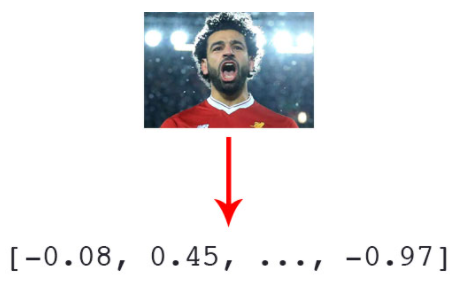

오늘 만나게 될 이미지 임베딩 모델은 위 그림처럼 이미지를 128차원의 얼굴임베딩 벡터로 변환해 줄 것.

임베딩 벡터에 보존되어야 하는 필요한 정보란? 

어떤 것의 절대적 의미를 벡터공간 상에 직접 부여할 수 있도록 하는 어떤 정보도 가지고 있지 않음. 우리가 가지고 있는 모든 정보는 상대적이기 때문임. A는 B에 비해 C에 더 가깝다라는 상대적인 비교 수치 말고는 우리가 컴퓨터에게 넘겨줄 수 있는 정보가 없음. 이런 정보가 최대한 보존되도록 어떤 오브젝트를 벡터 공간상에 매핑 시켜야 그 벡터는 매핑된 오브젝트의 임베딩 역할을 할 수 있게 됨.

[개요: 머신러닝을 위한 특성 임베딩 추출 및 제공](https://cloud.google.com/architecture/overview-extracting-and-serving-feature-embeddings-for-machine-learning?hl=ko)

임베딩이란?

__임베딩__은 고차원 벡터를 저차원 공간으로 변환하는 것. 

이상적으로, 임베딩은 임베딩 공간에서 의미적으로 비슷한 입력 사항들을 가깝게 배치함으로써 입력에 포함된 의미 중 일부를 포착함.


## 얼굴 임베딩 만들기 (1) 얼굴인식

이미지 속 두 얼굴이 얼마나 닮았는지 알아보기 위해 얼굴 임베딩 구하기 앞서 해결해야할 문제는 __이미지 속에서 얼굴 영역만을 정확하게 인식해서 추출해 내는 작업__임. 

얼굴인식 과정을 시작하려면 먼저 Input Image, 즉 얼굴이 들어있는 사진이 필요함. 

리고 사진에서 얼굴이 어디에 있는지 알아내기 위해서 Detection을 거치게 됨.

Detection을 해서 얼굴을 찾아내면 우리는 얼굴 이미지라고 부를 수 있을 만한 이미지 영역을 잘라내서(Crop) 얻어 낼 수 있음.

이렇게 잘라낸 얼굴 이미지는 딥러닝 네트워크를 거쳐 군집화(Clustering), 유사도(Similarity), 분류(Classification) 등 다양한 Task에 쓰일 수 있음.

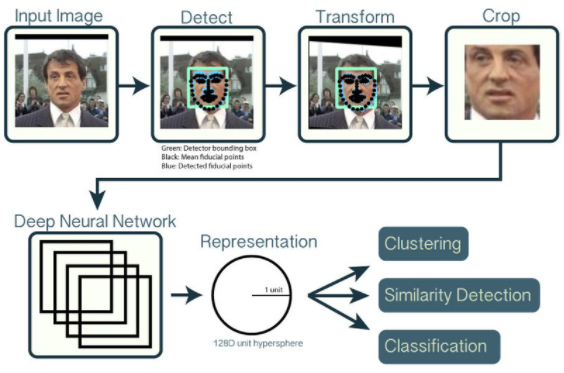

### 샘플 이미지 불러오기 

file_list: ['obama.jpg', 'clinton.jpeg', 'trump.jpg', 'reagan.jpg', 'bush.jpeg', 'biden.jpg']


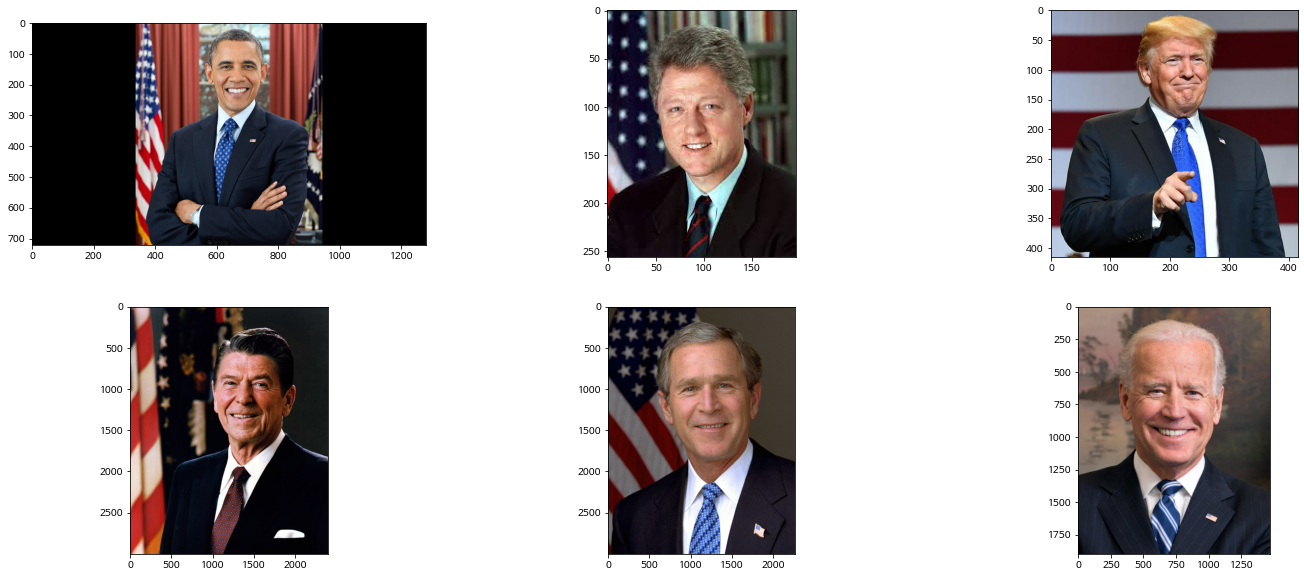

In [ ]:
import os 

dir_path = '/content/drive/MyDrive/aiffel/face_embedding/images'
file_list = os.listdir(dir_path)

print ("file_list: {}".format(file_list))

import matplotlib.pyplot as plt
import matplotlib.image as img

#Set figsize here
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(24,10))

# flatten axes for easy iterating
for i, ax in enumerate(axes.flatten()):
  image = img.imread(dir_path+'/'+file_list[i])
  ax.imshow(image)
plt.show()

fig.tight_layout()

### 2. 얼굴 찾기
샘플 이미지 `obama.jpg` 불러온 후 얼굴을 `face_recognition.face_locations`를 사용해 찾고 박스를 찾게 되면 임베딩 추출을 할 이미지를 만들기 위해 잘라줌.

In [ ]:
!pip install face_recognition

[(98, 758, 284, 572)]


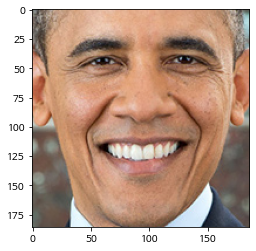

In [ ]:
import face_recognition
import os
%matplotlib inline
import matplotlib.pyplot as plt

image_path = '/content/drive/MyDrive/aiffel/face_embedding/images/obama.jpg'
image = face_recognition.load_image_file(image_path)
face_locations = face_recognition.face_locations(image)

print(face_locations)  # 이미지에서 얼굴 영역의 좌표를 출력합니다.

a, b, c, d = face_locations[0]
cropped_face = image[a:c,d:b,:]

plt.imshow(cropped_face)   # 이미지에서 얼굴영역만 잘라낸 cropped_face를 그려 봅니다.

방금 6명의 대통령 사진을 images 디렉토리에 저장해 둠. 이미지 파일 경로를 파라미터로 넘기면 얼굴 영역만 잘라서 뿌려주는 함수를 만들어두면 유용하게 사용 가능.

In [ ]:
import face_recognition
import os

def get_cropped_face(image_file):
    image = face_recognition.load_image_file(image_file)
    face_locations = face_recognition.face_locations(image)
    a, b, c, d = face_locations[0]
    cropped_face = image[a:c, d:b, :]
    
    return cropped_face

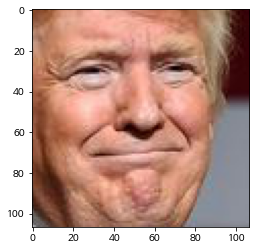

In [ ]:
image_path = '/content/drive/MyDrive/aiffel/face_embedding/images/trump.jpg'

cropped_face = get_cropped_face(image_path)
plt.imshow(cropped_face)

## 얼굴임베딩 만들기 (2) FaceNet

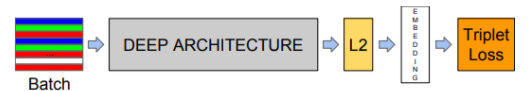



얼굴의 특징을 추출해서 적은 차원의 벡터로 만들기 위해서 딥러닝을 사용함. 

FaceNet은 우리가 봐왔던 딥러닝 모델과 크게 다른 것은 없지만 네트워크 뒤에 L2 Normalization을 거쳐 임베딩을 만들어 내고 여기에 Triplet Loss를 사용하고 있음.

L2 Normalization은 모델 결과물의 L2 Distance를 구한 후에 이것으로 결과물을 나눠주어 Normalization을 해주는 과정. 이렇게 L2 Normalization 레이어를 거쳐 나온 임베딩 벡터는 벡터의 크기가 1로 맞춰질 것이므로, 128차원의 공간상에 반지름이 1인 구가 있다고 할 때, 구의 표면상의 한 점을 가리키는 벡터처럼 분포될 것. 

이렇게 제약조건을 주면 이후 두 점 사이의 거리를 계산할 때 두 벡터의 절대적 크기에 무관하게 두 벡터 사이의 각도에만 영향을 받게 됨.

그럼 Triplet Loss는 무엇일까?

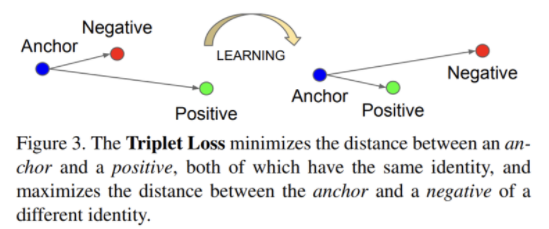


__Triplet Loss__ 는 이름에서 볼 수 있듯이 세 개의 데이터 쌍을 이용해 계산하는 손실함수로 네트워크를 학습시킬 수 있음.

시작할 때 임베딩 벡터 안에 보존되어야 할 정보는 A는 B에 비해 C에 더 가깝다 라는 상대적인 비교 수치밖에 없고 Triplet Loss 개념은 정확하게 이런 아이디어를 반영하고 있음. 

사람 얼굴 데이터셋에서 A와 C는 같은 사람의 얼굴 사진에서 나온 임베딩 벡터, B는 다른 사람의 얼굴 사진에서 만들어진 임베딩 벡터가 되도록 데이터셋을 구성. 그렇다면 정확히 A는 B에 비해 C에 더 가깝다 라는 논리가 성립해야만 할 것.

Triplet Loss는 같은 사람은 이 임베딩 벡터 A-C 간의 거리를 가깝게 그리고 다른 사람의 임베딩 벡터 B-C 간의 거리를 멀게 학습을 시키는 효과를 가져옴. 그림에서 보듯 같은 사람의 얼굴에서 나온 임베딩이 멀리 배치된다면 학습을 통해서 가까워지도록 임베딩 벡터를 만들어 내는 것!

[FaceNet: A Unified Embedding for Face Recognition and Clustering](https://arxiv.org/abs/1503.03832)

[C4W4L04 Triplet loss](https://www.youtube.com/watch?v=d2XB5-tuCWU)

### 1. 6장의 이미지에서 얼굴 임베딩을 추출
이전 스텝에서 얼굴 영역을 인식하는 데 사용했던 `Face Recognition`에는 바로 위에 소개한 `FaceNet` 얼굴 임베딩 모델이 탑재되어 있음.

이 모델을 이용하여 우리가 다운로드해 둔 6장의 이미지에서 얼굴 임베딩을 추출

In [ ]:
import os

dir_path = '/content/drive/MyDrive/aiffel/face_embedding/images'
file_list = os.listdir(dir_path)

print ("file_list: {}".format(file_list))

file_list: ['obama.jpg', 'clinton.jpeg', 'trump.jpg', 'reagan.jpg', 'bush.jpeg', 'biden.jpg']


### 2. 얼굴영역 임베딩 벡터 구하기
obama.jpg에 포함된 얼굴 영역의 임베딩 벡터 구하기. 

이미지 파일의 얼굴 영역을 가져오는 `get_cropped_face()` 함수 활용.

`Face Recognition` 패키지에서 제공하는 얼굴 임베딩 벡터를 구하는 함수는 `face_recognition.face_encodings()` 

In [ ]:
image_file = os.path.join(dir_path, 'obama.jpg')
face = get_cropped_face(image_file)   # 얼굴 영역을 구하는 함수(이전 스텝에서 구현)

# 얼굴 영역을 가지고 얼굴 임베딩 벡터를 구하는 함수
def get_face_embedding(face):
    return face_recognition.face_encodings(face)

embedding = get_face_embedding(face)  
embedding

[array([-0.08126256,  0.11014745, -0.01082445, -0.05268794,  0.01033718,
        -0.00813809, -0.07251757, -0.09226454,  0.19304717, -0.09246392,
         0.23908532,  0.06770284, -0.22123128, -0.14119357,  0.05562155,
         0.13705502, -0.17924429, -0.07232308, -0.11183279, -0.11370809,
         0.0395644 , -0.01019115,  0.09421775,  0.04493123, -0.12757549,
        -0.34449601, -0.05374936, -0.17703307,  0.00868223, -0.09721594,
        -0.09817182,  0.00278226, -0.17721353, -0.12789798,  0.03489836,
        -0.01991233, -0.00838929, -0.00132864,  0.18308596,  0.02447565,
        -0.12376569,  0.0995703 ,  0.02323563,  0.22983302,  0.28385252,
         0.06655712, -0.00558918, -0.0983355 ,  0.10058983, -0.23476952,
         0.06006293,  0.13415912,  0.08373035,  0.03900497,  0.10194533,
        -0.19337648,  0.01717629,  0.08978967, -0.16005114,  0.01892096,
         0.03082448, -0.06051282, -0.04526767,  0.04633339,  0.20678681,
         0.10299784, -0.12437528, -0.04905157,  0.1

2. 모든 이미지 파일의 임베딩 리턴 함수 만들기 

images 디렉토리 안에 있는 모든 이미지 파일의 임베딩을 구해서 dict 구조에 담아 리턴하는 함수 만들기. 

딕셔너리의 각 엘리먼트는 사람 이름:임베딩벡터. 

함수 이름은 `get_face_embedding_dict(dir_path)`이고, 
```python
embedding_dict = get_face_embedding_dict(dir_path):
embedding_dict['obama']  # obama.jpg의 얼굴임베딩 벡터
```
다음과 같이 사용

In [ ]:
def get_face_embedding_dict(dir_path):
    file_list = os.listdir(dir_path)
    embedding_dict = {}
    
    for file in file_list:
        img_path = os.path.join(dir_path, file)
        face = get_cropped_face(img_path)
        embedding = get_face_embedding(face)
        if len(embedding) > 0:  
        # 얼굴영역 face가 제대로 detect되지 않으면  len(embedding)==0인 경우가 발생하므로 
        # os.path.splitext(file)[0]에는 이미지파일명에서 확장자를 제거한 이름이 담깁니다. 
            embedding_dict[os.path.splitext(file)[0]] = embedding[0]
        
    return embedding_dict

In [ ]:
embedding_dict = get_face_embedding_dict(dir_path)
embedding_dict['trump']

array([-0.15962464,  0.20268655,  0.03236359,  0.02439231, -0.06226436,
        0.0514071 ,  0.07351796, -0.16823351,  0.06962208, -0.05557965,
        0.17270114, -0.05094172, -0.35293111, -0.03164373,  0.03792984,
        0.17343846, -0.13260125, -0.15357381, -0.23523535, -0.08442686,
       -0.00134151,  0.03210674, -0.08926155, -0.02670781, -0.09581175,
       -0.2579236 , -0.01057001, -0.11071666,  0.03133577, -0.07444926,
        0.05670559, -0.02273789, -0.19461143, -0.04576047,  0.00947575,
        0.01806061, -0.15026242, -0.07787324,  0.17577605,  0.0193326 ,
       -0.19744584, -0.03930523,  0.07374465,  0.20196036,  0.14767548,
       -0.01415397,  0.01724746, -0.11976209,  0.09462972, -0.24318142,
       -0.02755124,  0.12169893,  0.14837696,  0.17079782,  0.06952561,
       -0.15360464,  0.02005427,  0.08199152, -0.19544825,  0.10653655,
        0.11468485, -0.21902832, -0.07677592, -0.06791048,  0.105876  ,
        0.05921567, -0.06115698, -0.11171092,  0.23917486, -0.15

## 얼굴임베딩 사이의 거리측정

Triplet Loss는 설명 드린대로 같은 사람의 얼굴 쌍을 임베딩 공간 상에서 가깝도록 그리고 다른 사람의 얼굴 쌍을 멀도록 학습시킴. 즉, 이를 이용해 학습된 모델에서는 임베딩 공간에서 서로 다른 사람이라면 임베딩 거리가 멀게 표현.

그렇다면 이 모델에서 거리가 먼 두 얼굴 이미지의 임베딩은 서로 다른 사람일 확률이 높다고 볼 수 있고 가까우면 같은 사람일 확률이 높다고 볼 수 있음. 

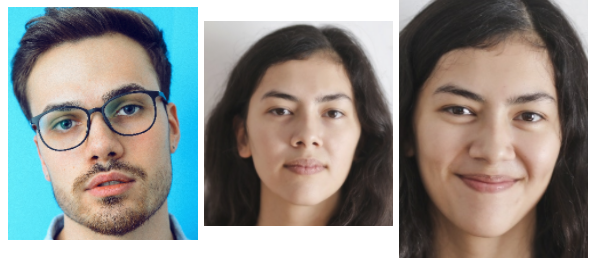

위의 세 사람의 사진(이미지 출처 : pexels.com) 을 Face Detection 모델로 미리 잘라 왔고 이전 스텝에서 사용했던 모델을 사용해서 128차원의 임베딩 벡터를 추출함. 순서대로 왼쪽부터 A, B, C에 각각 임베딩 벡터값을 넣어두었음. 물론 B와 C가 같은 사람이라는 것을 쉽게 알아볼 수 있지만 모델도 구분할 수 있도록 학습을 통해 임베딩 간의 거리가 확보됐는지를 먼저 확인.

In [ ]:
import numpy as np

A = np.array([0.0019173615146428347, 0.17689529061317444, 0.0763588473200798, -0.024574430659413338, -0.13141091167926788, 0.0344821996986866, -0.0374063216149807, -0.07056370377540588, 0.048655178397893906, -0.03414120525121689, 0.22696012258529663, -0.061402369290590286, -0.24329672753810883, -0.039421431720256805, 0.0621466189622879, 0.1220191940665245, -0.1616966724395752, -0.06176016479730606, -0.18894734978675842, -0.06051916256546974, -0.010404378175735474, -0.05918719246983528, 0.02205268107354641, -0.06932859122753143, -0.20260301232337952, -0.2425234317779541, -0.04454419016838074, -0.11400106549263, -0.02022719383239746, -0.15134216845035553, 0.07622595876455307, -0.0323314443230629, -0.1404413878917694, -0.056338660418987274, -0.04520038887858391, -0.026131991297006607, -0.0352761372923851, -0.0679447203874588, 0.1318240910768509, 0.034210119396448135, -0.17475582659244537, 0.13853909075260162, -0.0027398746460676193, 0.227312833070755, 0.3029572069644928, 0.004932125099003315, 0.05853061378002167, -0.07521739602088928, 0.1443275809288025, -0.2340908795595169, 0.030092637985944748, 0.040133409202098846, 0.1672351360321045, 0.05728958174586296, 0.11475440859794617, -0.07548368722200394, 0.040267568081617355, 0.16487033665180206, -0.21067440509796143, 0.036163005977869034, 0.051559075713157654, -0.05994952470064163, 0.029524143785238266, -0.04122130945324898, 0.13074155151844025, 0.1142958477139473, -0.00561982998624444, -0.09740489721298218, 0.18533651530742645, -0.10422169417142868, -0.11409182846546173, 0.02283927984535694, -0.08339140564203262, -0.13673236966133118, -0.3275497853755951, -0.0002689119428396225, 0.2842463254928589, 0.13883619010448456, -0.29149484634399414, -0.07276060432195663, -0.03179163485765457, 0.011192545294761658, 0.03802505508065224, 0.03392524644732475, -0.03972085565328598, -0.12013585865497589, -0.06272879987955093, -0.026893358677625656, 0.2430601865053177, -0.12022019177675247, -0.010466678068041801, 0.20199882984161377, 0.051095910370349884, -0.13243277370929718, 0.06056740880012512, -0.04802423343062401, -0.12318279594182968, -0.013157366774976254, -0.12076889723539352, -0.07183175534009933, -0.01982908323407173, -0.15032584965229034, -0.026652328670024872, 0.06820419430732727, -0.24668177962303162, 0.1818322390317917, -0.01959969662129879, -0.07208395004272461, -0.0680316612124443, -0.038368165493011475, 0.021410271525382996, 0.06388168036937714, 0.2293335199356079, -0.22541724145412445, 0.19133104383945465, 0.24343697726726532, -0.04034627974033356, 0.07534503191709518, 0.017645064741373062, 0.054646339267492294, -0.046512290835380554, 0.07076910138130188, -0.0960201621055603, -0.12610889971256256, -0.017934376373887062, -0.010262779891490936, 0.01885927841067314, 0.057148948311805725])

B = np.array([-0.08116298168897629, 0.1283080279827118, 0.024102725088596344, -0.03748808428645134, 0.06578215956687927, -0.07137967646121979, -0.10578329861164093, -0.0911930501461029, 0.19589228928089142, -0.09603863954544067, 0.2447616308927536, 0.07736924290657043, -0.17048686742782593, -0.1277867704629898, 0.06390697509050369, 0.12272421270608902, -0.19242052733898163, -0.08341517299413681, -0.11065894365310669, -0.09501136839389801, -0.010332206264138222, -0.008188878186047077, 0.08251037448644638, 0.04358505830168724, -0.1455313265323639, -0.3595622479915619, -0.07877802848815918, -0.18927346169948578, -0.0018955999985337257, -0.06280332803726196, -0.06073163449764252, 0.03181075677275658, -0.15109844505786896, -0.08682074397802353, 0.017340943217277527, -0.020879391580820084, 0.008258359506726265, 0.016738882288336754, 0.16803768277168274, 0.039162665605545044, -0.09613757580518723, 0.06231086328625679, 0.00924085732549429, 0.2418847680091858, 0.26051488518714905, 0.07355985790491104, 0.05239278823137283, -0.08052310347557068, 0.08884726464748383, -0.24261267483234406, 0.05618546903133392, 0.12175332009792328, 0.09056758135557175, 0.04266638681292534, 0.16591356694698334, -0.2005864679813385, 0.01018378883600235, 0.08819808065891266, -0.15550008416175842, 0.0815843716263771, 0.03018287755548954, -0.025435002520680428, -0.06714558601379395, 0.009693139232695103, 0.22243273258209229, 0.13470745086669922, -0.1363328993320465, 0.01635543815791607, 0.18212205171585083, -0.03392908349633217, 0.0398673489689827, 0.0043264636769890785, -0.15493592619895935, -0.2530894875526428, -0.23155181109905243, 0.0678660124540329, 0.31580865383148193, 0.21846994757652283, -0.20842058956623077, 0.012199334800243378, -0.12194785475730896, 0.059383176267147064, 0.0768171101808548, -0.012840969488024712, -0.11975857615470886, -0.11892750859260559, -0.03087366186082363, 0.04432998597621918, 0.09186872839927673, 0.0821407362818718, -0.018520792946219444, 0.1962793618440628, -0.0566205158829689, 0.026071354746818542, 0.007139421068131924, 0.02185123600065708, -0.11292634904384613, -0.044381096959114075, -0.18024618923664093, -0.007845945656299591, 0.010368190705776215, -0.07480168342590332, -0.0035089245066046715, 0.09972234815359116, -0.18773995339870453, 0.0474785715341568, 0.025760797783732414, -0.042169712483882904, 0.0014017894864082336, 0.1201503798365593, -0.05088714882731438, -0.02051539719104767, 0.0884844958782196, -0.2176845818758011, 0.25695914030075073, 0.23358485102653503, 0.019985560327768326, 0.17838242650032043, 0.029055196791887283, 0.04518195986747742, -0.044122979044914246, -0.043431997299194336, -0.15906637907028198, -0.07155231386423111, 0.02525237947702408, 0.02502967044711113, 0.04127159342169762, 0.011846683919429779])

C = np.array([-0.0762145072221756, 0.09951083362102509, 0.0012626983225345612, -0.05529194697737694, -0.006535547785460949, -0.012212716042995453, -0.07667708396911621, -0.07388101518154144, 0.18756520748138428, -0.07589773088693619, 0.2424328476190567, 0.06438330560922623, -0.22197730839252472, -0.13409815728664398, 0.046808283776044846, 0.14692817628383636, -0.1844339370727539, -0.051137253642082214, -0.1149090975522995, -0.1297808736562729, 0.040612753480672836, -0.002555673476308584, 0.10426937788724899, 0.026295233517885208, -0.13127824664115906, -0.35947439074516296, -0.048153407871723175, -0.17165206372737885, -0.0002263905480504036, -0.10254599899053574, -0.08338439464569092, 0.014203382655978203, -0.18179851770401, -0.13200539350509644, 0.03813670203089714, -0.012789442203938961, -0.0030085663311183453, -0.007307708729058504, 0.17558619379997253, 0.025768719613552094, -0.12877899408340454, 0.11051110923290253, 0.03616628795862198, 0.22539083659648895, 0.2838597595691681, 0.07483825087547302, -0.0036694444715976715, -0.09967216849327087, 0.11106447875499725, -0.22961333394050598, 0.06397823244333267, 0.12394970655441284, 0.06568531692028046, 0.037825535982847214, 0.09586739540100098, -0.18721607327461243, 0.01674063131213188, 0.10057111084461212, -0.15766742825508118, 0.008397659286856651, 0.039109550416469574, -0.06041106954216957, -0.046033550053834915, 0.031240269541740417, 0.2121172845363617, 0.103468157351017, -0.1224282756447792, -0.05559460073709488, 0.12153220176696777, -0.018480442464351654, 0.039875734597444534, 0.007489997893571854, -0.18950346112251282, -0.20904967188835144, -0.23732705414295197, 0.0895664244890213, 0.3778454661369324, 0.16606193780899048, -0.20442475378513336, 0.018602905794978142, -0.18367978930473328, 0.04945264756679535, 0.08889186382293701, 0.002995049115270376, -0.06196683272719383, -0.13028381764888763, -0.03548961132764816, 0.053789377212524414, 0.08386979252099991, 0.016627438366413116, -0.040179431438446045, 0.2289249151945114, -0.02149147540330887, 0.05046383664011955, 0.02314644865691662, 0.05424635857343674, -0.1627081036567688, -0.01140156015753746, -0.18031321465969086, -0.06785157322883606, 0.03336677327752113, -0.06467186659574509, 0.0466950424015522, 0.12832939624786377, -0.2377130389213562, 0.06774994730949402, 0.013810726813971996, -0.019034255295991898, 0.04477768391370773, 0.0660984218120575, -0.031004268676042557, -0.03275192156434059, 0.06632497161626816, -0.24120087921619415, 0.2647172510623932, 0.2477877289056778, 0.054315339773893356, 0.17328208684921265, 0.06950142979621887, 0.019016757607460022, -0.01211759727448225, -0.014044362120330334, -0.17701464891433716, -0.03347969055175781, 0.04914966598153114, 0.05660251900553703, 0.0644666999578476, 0.012375651858747005])

print("슝=3")

슝=3


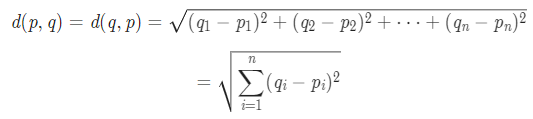

각 128차원의 벡터는 넘파이(Numpy)로 연산을 하기 위해서 리스트(list)에서 넘파이 배열(Numpy Array)로 변환.

그리고 각 벡터간의 거리를 numpy.linalg.norm를 활용하여 L2 Norm Distance로 계산. 

L2 Norm Distance는 위의 식처럼 각 차원의 차이를 제곱한 뒤 합한 후 제곱근을 구한 값. (2차원 유클리디안 거리를 다차원으로 확장시킨 것)

In [ ]:
distances = np.linalg.norm([A, B] - C, axis=1, ord=2)
print("Distance between A and C: {}".format(distances[0]))
print("Distance between B and C: {}".format(distances[1]))

Distance between A and C: 0.8211549091846528
Distance between B and C: 0.34743558135053815


위 계산 결과에서 볼 수 있듯이 같은 사람인 B와 C의 거리는 0.3474로 다른 사람 간의 거리(A와 C)인 0.8212보다 상대적으로 작은 것을 볼 수 있음.

이렇게 임베딩으로 사람 얼굴을 비교하고 누가 같은 사람인지를 비교할 수 있다면 임베딩 벡터의 거리가 가까운 얼굴일수록 닮았다고 볼 수 있을 것.

<br>

***
<br>

L2 distance 대신 L1 distance로 계산할 경우 __전체적인 distance 값의 분포가 커짐__

In [ ]:
distances = np.linalg.norm([A, B] - C, axis=1, ord=1)
print("Distance between A and C: {}".format(distances[0]))
print("Distance between B and C: {}".format(distances[1]))

Distance between A and C: 7.720474720699713
Distance between B and C: 3.1546838842332363


In [ ]:
import numpy as np

x = np.array([1,2,3,4,5])
y = np.array([2,3,4,5,6])

print(np.linalg.norm(y-x, ord=1))  #L1 distance
print(np.linalg.norm(y-x, ord=2))  #L2 distance

5.0
2.23606797749979


이전 스텝에서 우리가 가지고 있는 이미지의 얼굴 임베딩을 이미 다 구해 두었음. 이제는 두 임베딩 벡터 간의 거리를 계산하는 함수를 구현해야함. 위에서 살펴본 `np.linalg.norm`를 활용하면 쉽게 구할 수 있음.

아래의 `get_distance()` 함수는 인자로 파일명의 사람 이름 2개를 받아서, 두 사람의 얼굴 임베딩 사이의 거리(L2 distance)를 구하는 형태.

In [ ]:
def get_distance(name1, name2):
    return np.linalg.norm(embedding_dict[name1]-embedding_dict[name2], ord=2)

get_distance('obama', 'trump')

0.8885118419887265

## 얼굴임베딩 공간의 시각화 

고차원 데이터를 저차원으로 바꾼 임베딩처럼 이런 다차원 벡터를 시각화하기 위해서 차원 축소(__PCA, T-SNE__)를 하는 방법들이 있음. 

TensorFlow의 Projector는 고차원 벡터를 차원 축소 기법을 사용해서 눈으로 확인할 수 있게 해줌. 

[128D FaceNet LFW Embedding Visualization](https://huyhoang17.github.io/128D-Facenet-LFW-Embedding-Visualisation/)

PCA 와 T-SNE 를 이용해 우리가 쉽게 볼 수 있는 형태로 차원을 축소할 수 있음.

* 먼저 PCA 는 주성분 분석이라는 방법으로 Principal Component Analysis 의 준말입니다. 이 방법은 모든 차원의 축에 따른 값의 변화도인 분산(Variance)을 확인한 뒤 그 중 변화가 가장 큰 주요한 축을 남기는 방법입니다.

* T-SNE 는 고차원 상에서 먼 거리를 저차원 상에서도 멀리 배치되도록 차원을 축소하는 방식입니다. 먼저 random하게 목표하는 차원에 데이터들을 배치한 후 각 데이터들을 고차원 상에서의 배치와 비교를 하면서 위치를 변경해 주는 알고리즘으로 이해하시면 됩니다.

위의 시각화에서 보듯이 PCA에서는 모든 차원이 잘 반영되지 않는 반면 T-SNE는 Iteration을 거칠수록 가까운 벡터들이 잘 군집한 형태로 차원 축소가 되는 것을 볼 수 있음. 
* PCA: [차원 감소와 PCA 분석](https://bcho.tistory.com/1209?category=555440)
* T-SNE: [(영상) StatQuest: t-SNE, Clearly Explained](https://www.youtube.com/watch?v=NEaUSP4YerM)


## 가장 닮은꼴 얼굴 찾아보기 

* `def get_cropped_face(image_file)` : 이미지 파일에서 얼굴 영역을 가져오는 함수

* `def get_face_embedding(face)` : 얼굴영역으로부터 얼굴 임베딩 벡터를 구하는 함수

* `def get_face_embedding_dict(dir_path)` : 디렉토리 안에 있는 모든 이미지의 임베딩 딕셔너리를 구하는 함수

* `def get_distance(name1, name2)` : 두 이미지(사람 이름) 사이의 임베딩 벡터 거리를 구하는 함수

이제 필요한 정보를 다 가지고 있으므로, 이제는 특정 이미지와 가장 닮은 이미지를 구해보는 기능을 만들 수 있을 것.

우리가 만들고 싶은 함수는 다음과 같이 쓰길 바람. name 인자에 특정 사람 이름을 주면 그 사람과 가장 닮은 다른 이미지와 거리 정보를 가장 가까운 순으로 정렬해서 표시해 주어야 함.

```
수행결과

순위 1 : 이름(biden), 거리(0.682061661275583)
순위 2 : 이름(clinton), 거리(0.6875851008652103)
순위 3 : ... (이하생략)
```

In [ ]:
def get_nearest_face(name, top=5): 
    pass
get_nearest_face('trump')

In [ ]:
# name1과 name2의 거리를 비교하는 함수를 생성하되, name1은 미리 지정하고, name2는 호출시에 인자로 받도록 합니다.
def get_sort_key_func(name1):
    def get_distance_from_name1(name2):
        return get_distance(name1, name2)
    return get_distance_from_name1

sort_key_func = get_sort_key_func('trump')   
# 이렇게 생성된 함수 sort_key_func는 sort_key_func('obama') 라고 호출할 때 trump와 obama 사이의 임베딩 벡터 거리를 계산합니다.

우리는 이미 모든 이미지 파일에 대한 얼굴 임베딩 딕셔너리를 가지고 있음.

이제 우리는 이 딕셔너리를 오름차순 정렬하되, 정렬 기준을 바로 trump와의 임베딩 벡터 거리 함수로 할 것. (이때 lambda 함수가 정렬 key로 활용)

이제 'trump'에 대해서가 아니라, 입력받은 임의의 이름에 대해 다른 이미지의 임베딩 거리를 정렬해서 적절히 출력. 

In [ ]:
def get_nearest_face(name, top=5):
    sort_key_func = get_sort_key_func(name)
    sorted_faces = sorted(embedding_dict.items(), key=lambda x:sort_key_func(x[0]))
    
    for i in range(top+1):
        if i == 0 :   # 첫번째로 나오는 이름은 자기 자신일 것이므로 제외합시다. 
            continue
        if sorted_faces[i]:
            print('순위 {} : 이름({}), 거리({})'.format(i, sorted_faces[i][0], sort_key_func(sorted_faces[i][0])))

In [ ]:
# obama와 가장 닮은 사람은 누굴까요?
get_nearest_face('obama')

순위 1 : 이름(권태원), 거리(0.6624371512650244)
순위 2 : 이름(김C), 거리(0.697446910354349)
순위 3 : 이름(성룡), 거리(0.7058108304449672)
순위 4 : 이름(김연우), 거리(0.715641977710045)
순위 5 : 이름(이정재), 거리(0.7166227180846328)


# 프로젝트 : 나랑 닮은 연예인 찾아보자 

## STEP1. 얼굴인식
샘플이미지 불러오기

In [60]:
import os 

dir_path = '/content/drive/MyDrive/aiffel/face_embedding/project'
file_list = os.listdir(dir_path)

file_list[:5]

['시우민.jpg', 'obama.jpg', 'clinton.jpeg', 'trump.jpg', '고창석.jpeg']

샘플 이미지의 `me.jpg`를 불러온 후 얼굴을 `face_recognition.face_locations`를 사용해 찾아줌

In [61]:
pip install face_recognition

In [62]:
import face_recognition
import os
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as img

박스를 찾게 되면 임베딩 추출 할 이미지를 만들기 위해 잘라줌 

In [63]:
def get_cropped_face(image_file):
    image = face_recognition.load_image_file(image_file)
    face_locations = face_recognition.face_locations(image)
    a, b, c, d = face_locations[0]
    cropped_face = image[a:c,d:b,:]
    
    return cropped_face

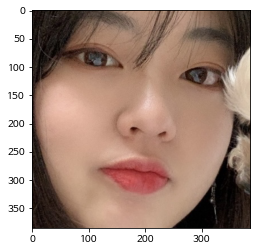

In [64]:
image_path = '/content/drive/MyDrive/aiffel/face_embedding/project/me.jpg'

cropped_face = get_cropped_face(image_path)
plt.imshow(cropped_face)

## STEP2. FaceNet

딕셔너리 keyerror 방지하기 위해 파일 저장방식 NFC로 지정

In [65]:
from unicodedata import normalize

def list_files(dir_path):
  nfd_file_list = os.listdir(dir_path)

  file_list = []
  for nfd_file in nfd_file_list:
    file = normalize("NFC", nfd_file)
    file_list.append(file)
  return file_list
file_list = list_files(dir_path)

In [95]:
dir_path = '/content/drive/MyDrive/aiffel/face_embedding/project/'
file_list = os.listdir(dir_path)

file_list[:5]

['시우민.jpg', 'obama.jpg', 'clinton.jpeg', 'trump.jpg', '고창석.jpeg']

`face_recognition.face_encodings()`를 사용해 얼굴 임베딩 벡터 구함

In [67]:
image_file = os.path.join(dir_path, 'me.jpg')
face = get_cropped_face(image_file)   # 얼굴 영역을 구하는 함수(이전 스텝에서 구현)

# 얼굴 영역을 가지고 얼굴 임베딩 벡터를 구하는 함수
def get_face_embedding(face):
    return face_recognition.face_encodings(face)

embedding = get_face_embedding(face)  
embedding

[array([-0.07049313,  0.05683836,  0.01423346, -0.09899547, -0.11271358,
        -0.09396882, -0.12021219, -0.10519958,  0.10784433, -0.1517956 ,
         0.15921409, -0.1202442 , -0.16564557, -0.05468887, -0.04593953,
         0.2326515 , -0.17020908, -0.18668753, -0.02760581, -0.01084469,
         0.08657952,  0.02941594, -0.02872453,  0.10489137, -0.13120253,
        -0.31588644, -0.10109666, -0.06630256, -0.05362293, -0.04484794,
         0.0295173 ,  0.10439312, -0.16920888, -0.00228571,  0.05694656,
         0.10481562,  0.04466796, -0.06675572,  0.16033623, -0.03384467,
        -0.33362263,  0.06105307,  0.11695325,  0.24710429,  0.15102164,
        -0.00685333,  0.00382791, -0.1807262 ,  0.12551713, -0.12478406,
         0.02580227,  0.13595112,  0.02014982,  0.05139919,  0.03206879,
        -0.11192376,  0.11343783,  0.13002545, -0.16172852, -0.02576487,
         0.09538235, -0.0794269 ,  0.03177234, -0.09858932,  0.23751548,
         0.05558278, -0.0993352 , -0.20950714,  0.1

In [68]:
def get_face_embedding_dict(dir_path):
    file_list = list_files(dir_path)
    embedding_dict = {}
    
    for file in file_list:
        img_path = os.path.join(dir_path, file)
        face = get_cropped_face(img_path)
        embedding = get_face_embedding(face)
        if len(embedding) > 0:  
        # 얼굴영역 face가 제대로 detect되지 않으면  len(embedding)==0인 경우가 발생하므로 
        # os.path.splitext(file)[0]에는 이미지파일명에서 확장자를 제거한 이름이 담깁니다. 
            embedding_dict[os.path.splitext(file)[0]] = embedding[0]
        
    return embedding_dict

In [69]:
embedding_dict = get_face_embedding_dict(dir_path)

## STEP3. 얼굴 임베딩 사이의 거리 측정

`np.linalg.norm`를 활용해 두 사람의 얼굴 임베딩 사이 거리(L2 distance)를 구하는 `get_distance()` 함수 만들기 

In [70]:
import numpy as np

def get_distance(name1, name2):
    return np.linalg.norm(embedding_dict[name1]-embedding_dict[name2], ord=2)

get_distance('문재인', 'me')

0.6726183565565157

## STEP4. 가장 닮은꼴 얼굴 찾아보기 

* `def get_cropped_face(image_file)` : 이미지 파일에서 얼굴 영역을 가져오는 함수

* `def get_face_embedding(face)` : 얼굴영역으로부터 얼굴 임베딩 벡터를 구하는 함수

* `def get_face_embedding_dict(dir_path)` : 디렉토리 안에 있는 모든 이미지의 임베딩 딕셔너리를 구하는 함수

* `def get_distance(name1, name2)` : 두 이미지(사람 이름) 사이의 임베딩 벡터 거리를 구하는 함수

In [71]:
def get_nearest_face(name, top=5): 
    pass
get_nearest_face('me')

In [72]:
# name1과 name2의 거리를 비교하는 함수를 생성하되, name1은 미리 지정하고, name2는 호출시에 인자로 받도록 합니다.
def get_sort_key_func(name1):
    def get_distance_from_name1(name2):
        return get_distance(name1, name2)
    return get_distance_from_name1

sort_key_func = get_sort_key_func('me')   
# 이렇게 생성된 함수 sort_key_func는 sort_key_func('obama') 라고 호출할 때 trump와 obama 사이의 임베딩 벡터 거리를 계산합니다.

In [73]:
def get_nearest_face(name, top=5):
    sort_key_func = get_sort_key_func(name)
    sorted_faces = sorted(embedding_dict.items(), key=lambda x:sort_key_func(x[0]))
    
    for i in range(top+1):
        if i == 0 :   # 첫번째로 나오는 이름은 자기 자신일 것이므로 제외합시다. 
            continue
        if sorted_faces[i]:
            print('순위 {} : 이름({}), 거리({})'.format(i, sorted_faces[i][0], sort_key_func(sorted_faces[i][0])))
    return sorted_faces, sort_key_func

나와 가장 닮은 사람은?

In [74]:
sorted_faces, sort_key_func = get_nearest_face('me')

순위 1 : 이름(우기), 거리(0.3540587309097101)
순위 2 : 이름(사쿠라), 거리(0.3548944138150969)
순위 3 : 이름(리아), 거리(0.36611962561073375)
순위 4 : 이름(아이즈원민주), 거리(0.3685565737202869)
순위 5 : 이름(트와이스쯔위), 거리(0.3716935054825558)


## 시각화 

한글 깨짐 현상 해결 

In [75]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm !/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache directory
fc-cache: succeeded


In [76]:
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')

나와 닮은 TOP 5 연예인 이름 list 저장

In [77]:
name_list = []
for idx in range(1,6):
  new_path = str(dir_path+sorted_faces[idx][0]+".jpg")
  path, files = os.path.split(new_path)
  name,  ext= os.path.splitext(files)
  name_list.append(name)
name_list

['우기', '사쿠라', '리아', '아이즈원민주', '트와이스쯔위']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


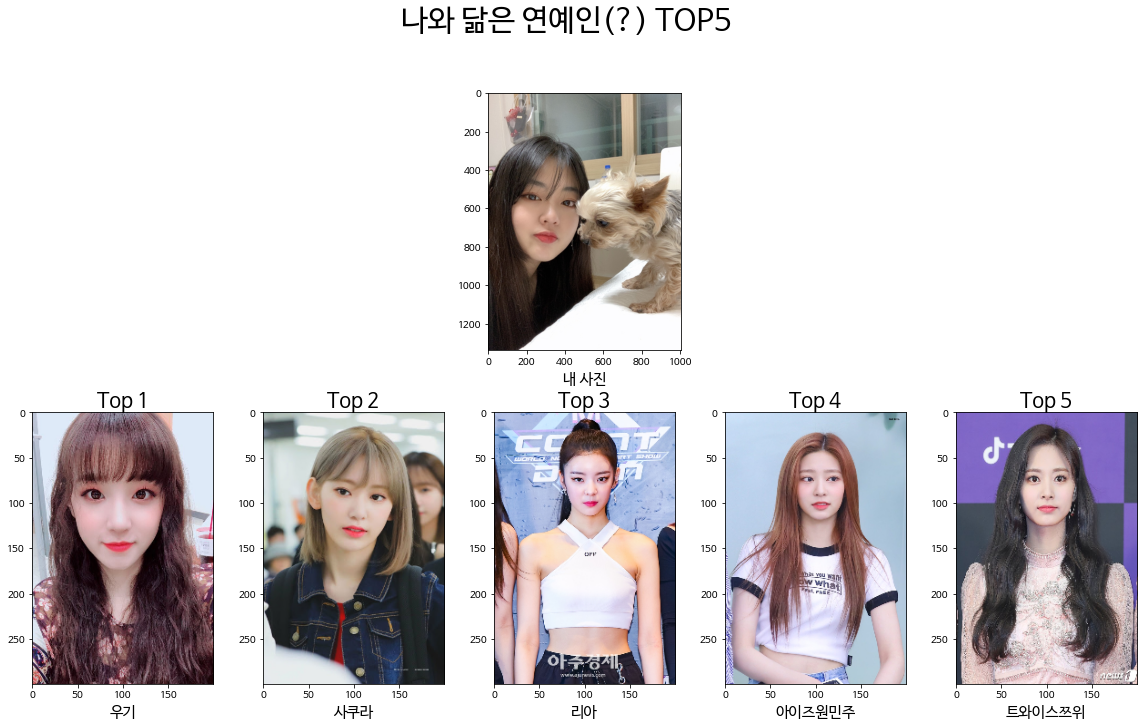

In [93]:
import cv2

plt.figure(figsize=(20, 11))


for idx, top_img_num in enumerate(sorted_faces[1:6]):

  top_img = cv2.imread(dir_path+sorted_faces[idx+1][0]+".jpg")
  top_img = cv2.resize(top_img, (200, 300))
  top_img = cv2.cvtColor(top_img, cv2.COLOR_BGR2RGB)
  plt.subplot(2, 5, idx+6)
  plt.subplot
  plt.imshow(top_img)
  plt.title('Top {}'.format(idx+1), fontsize=20)
  plt.suptitle('나와 닮은 연예인(?) TOP5', fontsize=30)
  plt.xlabel('{}'.format(name_list[idx]), fontsize=15)
  plt.subplot(2, 5, 3)
  my_img = cv2.imread(image_path)
  my_img = cv2.cvtColor(my_img, cv2.COLOR_BGR2RGB)
  plt.imshow(my_img)
  plt.xlabel('내 사진', fontsize=15)

# 회고 

이번 프로젝트는 코딩하는 과정은 LMS에서 배운대로 따라가면 되기 때문에 그렇게 어렵지 않았다. 하지만 데이터를 가져오고 얼굴인식이 되지 않는 이미지에 대한 처리가 어려웠기 때문에 인식이 되지 않는 이미지는 삭제하고 진행하였다. 

그리고 `plt`을 사용해 시각화를 진행하는 부분이 어려웠다. subplot을 그릴 때, xlabel로 바로 추가하고 싶었지만 잘 되지않아, list로 따로 뽑았다. 돌고돌아 마지막 시각화를 했기 때문에 더 공부해서 조금 더 간단한 코드를 만들고 싶다. 



_참고_

[https://asthtls.tistory.com/1011](https://asthtls.tistory.com/1011)

[matplotlib의 기본 사용법 및 다른 시각화 라이브러리](https://soooprmx.com/matplotlib%EC%9D%98-%EA%B8%B0%EB%B3%B8-%EC%82%AC%EC%9A%A9%EB%B2%95-%EB%B0%8F-%EB%8B%A4%EB%A5%B8-%EC%8B%9C%EA%B0%81%ED%99%94-%EB%9D%BC%EC%9D%B4%EB%B8%8C%EB%9F%AC%EB%A6%AC/)

[구글 코랩(colab) 한글 깨짐 현상 해결방법](https://teddylee777.github.io/colab/colab-korean)

[파이썬의 파일 확장자 알아보기-splitext 함수](https://redcow77.tistory.com/371)